In [1]:
#%matplotlib notebook
import time, winsound, h5py
import numpy as np
import matplotlib.pyplot as plt
from lcls_beamline_toolbox.xraybeamline2d import beam1d as beam, optics1d as optics, beamline1d as beamline

### Beam parameters

In [2]:
# number of sampling points
N = 2048
# photon energy in eV
E0 = 17795

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 630
}

### Propagate central energy only (no time component) to tune lens roc

In [3]:
def define_devices(E0=E0):
    # asymmetry angle
    #etaA = np.deg2rad(9.87)
    #etaB = np.deg2rad(68.78)
    etaA = np.deg2rad(9.4)
    etaB = np.deg2rad(70)
    etaC = etaA
    
    # crystal reflection hkl index
    hklA = [4,0,0]
    hklB = [12,8,4]
    hklC = hklA
    
    FOV = 200e-3
    N = 100
    
    # viewing point upstream of monochromator
    im0 = optics.PPM('im0', z=870, FOV=FOV, N=256)
    crl0 = optics.CRL('crl0', z=920, E0=E0, f=290., diameter=10e-3)

    # crystal pair A
    crystal1 = optics.Crystal('c1', hkl=hklA, length=10e-2, width=20e-3, z=930., E0=E0,
                              alphaAsym=-etaA, orientation=2, pol='s')
    
    z2 = crystal1.z + np.cos(crystal1.alpha+crystal1.beta0)*0.2
    crystal2 = optics.Crystal('c2', hkl=hklA, length=50e-2, width=20e-3, z=z2, E0=E0,
                              alphaAsym=-etaA, orientation=0,pol='s')
    
    # viewing point for pair A
    #im1 = optics.PPM('after_A', z=crystal2.z+.1,N=2048,FOV=16e-3)
    im1_1 = optics.PPM('after_c1', z=crystal1.z+1e-3,FOV = FOV, N = N)
    im1_2 = optics.PPM('after_c2', z=crystal2.z+1e-3,FOV = FOV, N = N)

    # crystal pair B
    crystal3 = optics.Crystal('c3', hkl=hklB, length=200e-2, width=20e-3, z=crystal2.z+.5, E0=E0,
                              alphaAsym=etaB, orientation=0, pol='s')
    
    z4 = crystal3.z + np.cos(crystal3.alpha+crystal3.beta0)*0.5
    crystal4 = optics.Crystal('c4', hkl=hklB, length=200e-2, width=20e-3, z=z4, E0=E0,
                              alphaAsym=-etaB, orientation=2, pol='s')
    # viewing point for pair B
    #im2 = optics.PPM('after_B', z=crystal4.z+.1,N=2048,FOV=16e-3)
    im2_1 = optics.PPM('after_c3', z=crystal3.z-1e-3,FOV = FOV, N = N)
    im2_2 = optics.PPM('after_c4', z=crystal4.z+1e-3,FOV = FOV, N = N)
    
    # crystal pair C
    crystal5 = optics.Crystal('c5', hkl=hklC, length=50e-2, width=20e-3, z=crystal4.z+.5, E0=E0,
                              alphaAsym=etaC, orientation=2, pol='s')
    
    z6 = crystal5.z + np.cos(crystal5.alpha+crystal5.beta0)*0.2
    crystal6 = optics.Crystal('c6', hkl=hklC, length=10e-2, width=20e-3, z=z6, E0=E0,
                              alphaAsym=etaC, orientation=0, pol='s')

    # viewing point for pair C
    im3_1 = optics.PPM('after_c5', z=crystal5.z+1e-3, FOV = FOV, N = N)
    im3_2 = optics.PPM('output',   z=crystal6.z+1e-3, FOV = FOV, N = N)

    # list of devices to propagate through
    devices = [im0, crl0, crystal1, im1_1, crystal2, im1_2, crystal3, im2_1, crystal4, im2_2, crystal5, im3_1, crystal6, im3_2]
    return devices

In [4]:
# checking devices
devices = define_devices()
for device in devices:
    if device.name[0] == 'c':
        if device.name != 'crl0':
            print('\n'+device.name)
            print('Position {}m'.format(round(device.z,2)))
            print('Incident angle {} deg'.format(round(np.rad2deg(device.alpha),2)))
            print('Diffraction angle {} deg'.format(round(np.rad2deg(device.beta0),2)))
            print('Bragg angle {} deg'.format(round(np.rad2deg((device.alpha+device.beta0)/2),2)))

b 0.23
b 0.23
b 8.90
b 0.11
b 4.31
b 4.31

c1
Position 930.0m
Incident angle 5.47 deg
Diffraction angle 24.27 deg
Bragg angle 14.87 deg

c2
Position 930.17m
Incident angle 5.47 deg
Diffraction angle 24.27 deg
Bragg angle 14.87 deg

c3
Position 930.67m
Incident angle 143.75 deg
Diffraction angle 3.81 deg
Bragg angle 73.78 deg

c4
Position 930.25m
Incident angle 3.75 deg
Diffraction angle 143.75 deg
Bragg angle 73.75 deg

c5
Position 930.75m
Incident angle 24.27 deg
Diffraction angle 5.47 deg
Bragg angle 14.87 deg

c6
Position 930.93m
Incident angle 24.27 deg
Diffraction angle 5.47 deg
Bragg angle 14.87 deg


### Propagate energy components and plot beam profiles


In [5]:
%%capture capt
tstart = time.time()
# initialize optical elements
devices = define_devices()

# initialize beamline
mono_beamline = beamline.Beamline(devices)
# propagate
beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, tau=400, time_window=1000000)
pulse.propagate(beamline=mono_beamline, screen_names=[
    'im0', 'after_c1', 'after_c2', 'after_c3', 'after_c4', 'after_c5','output'])
#pulse.propagate(beamline=mono_beamline, screen_names=['im0', 'output'])
tfin = time.time()

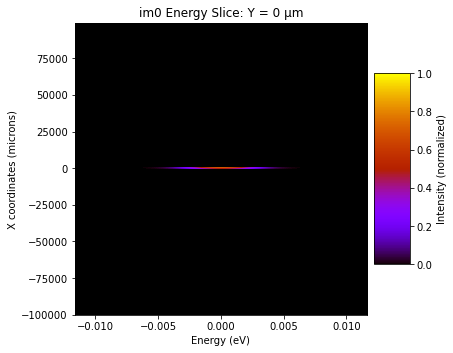

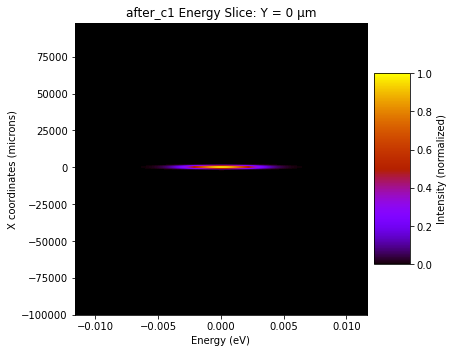

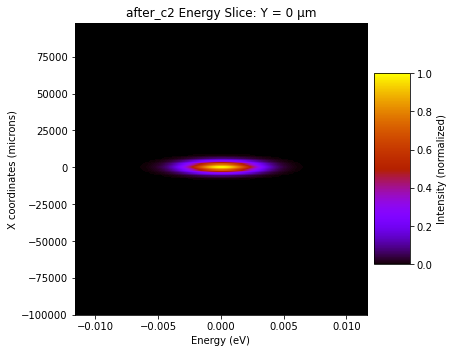

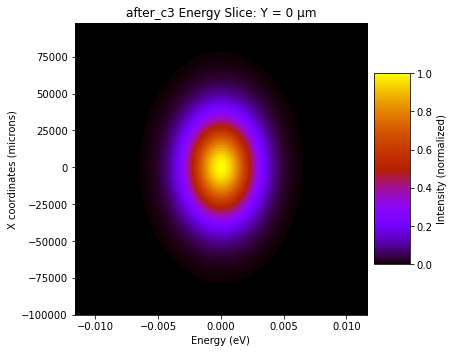

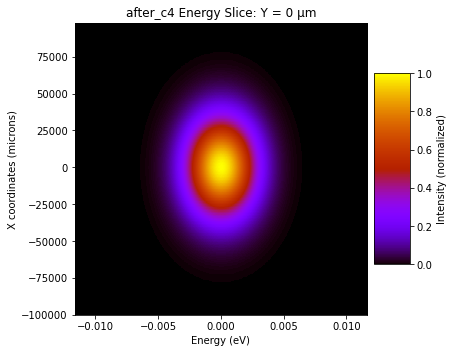

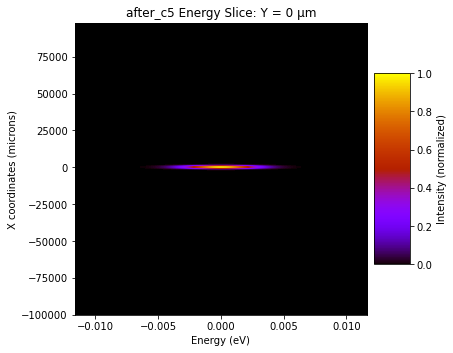

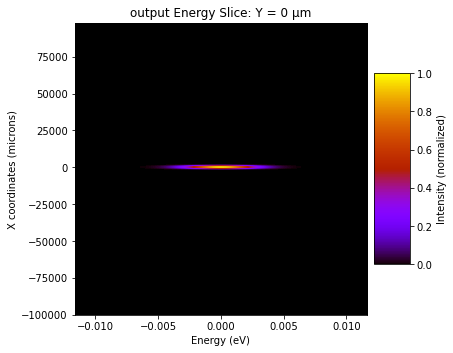

In [6]:
''' energy slices '''
pulse.imshow_energy_slice('im0')
pulse.imshow_energy_slice('after_c1')
pulse.imshow_energy_slice('after_c2')
pulse.imshow_energy_slice('after_c3')
pulse.imshow_energy_slice('after_c4')
pulse.imshow_energy_slice('after_c5')
pulse.imshow_energy_slice('output')

(<matplotlib.axes._subplots.AxesSubplot at 0x214e79acc88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x214e79ba508>)

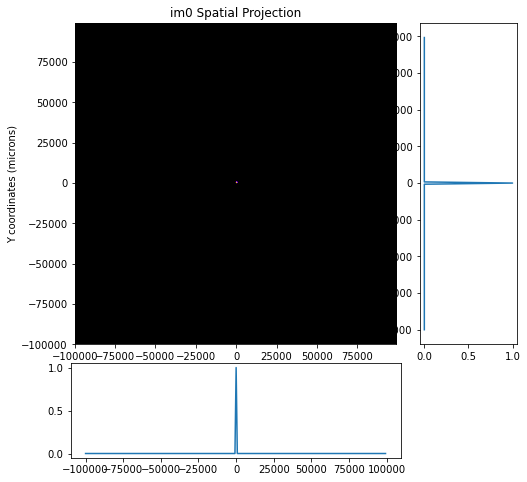

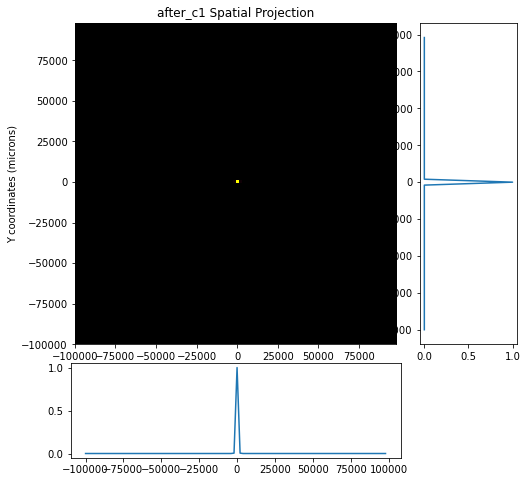

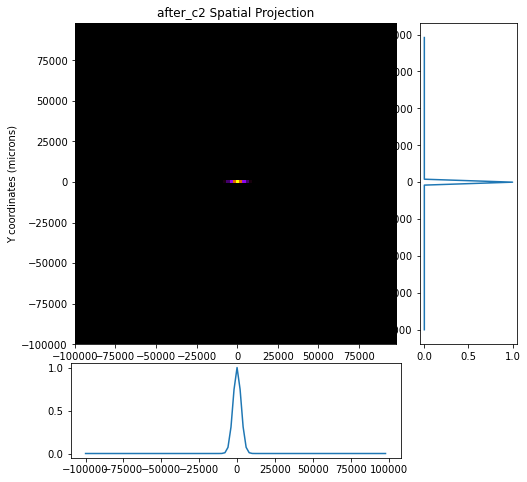

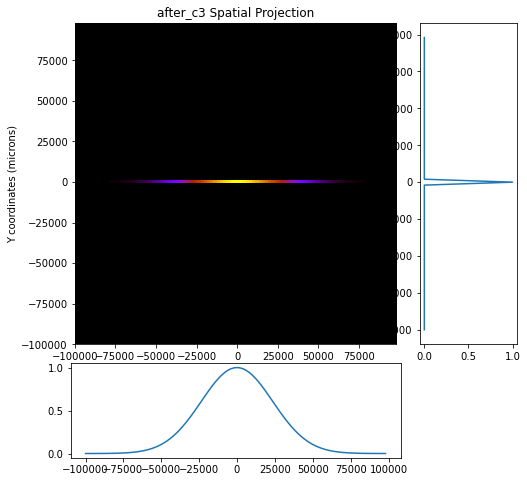

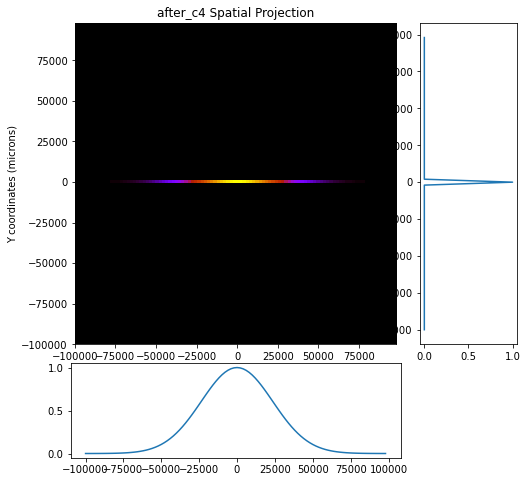

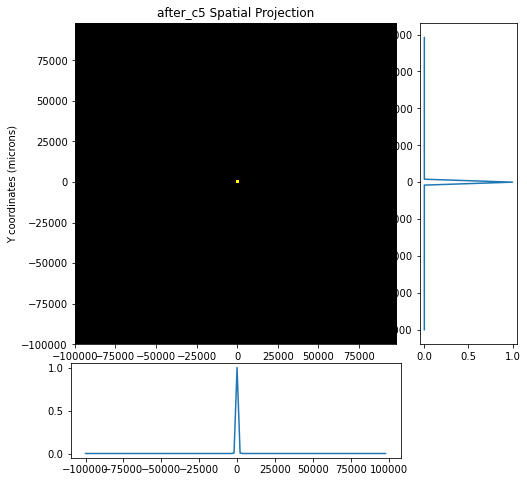

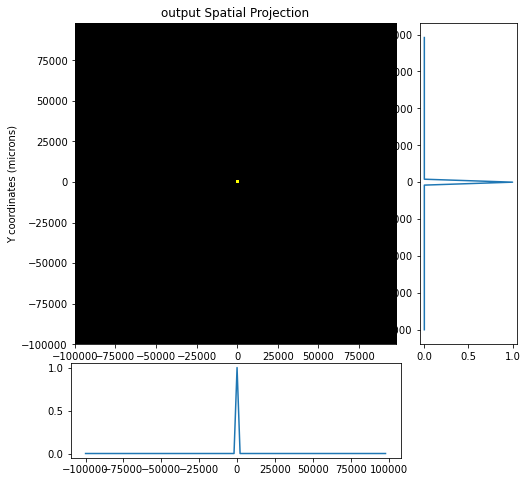

In [7]:
''' spatial projection (x,y)'''
pulse.imshow_projection('im0')
pulse.imshow_projection('after_c1')
pulse.imshow_projection('after_c2')
pulse.imshow_projection('after_c3')
pulse.imshow_projection('after_c4')
pulse.imshow_projection('after_c5')
pulse.imshow_projection('output')


total 885.03s, per slice 157.45ms


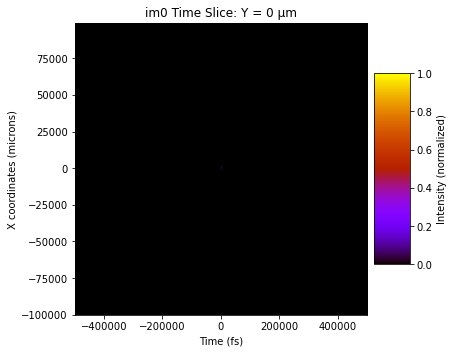

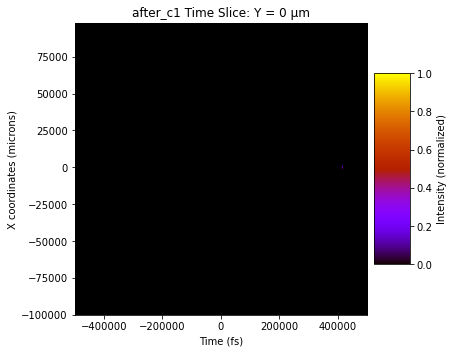

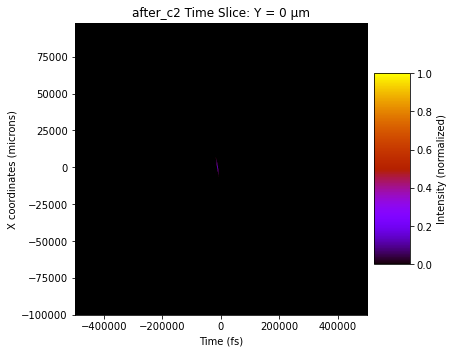

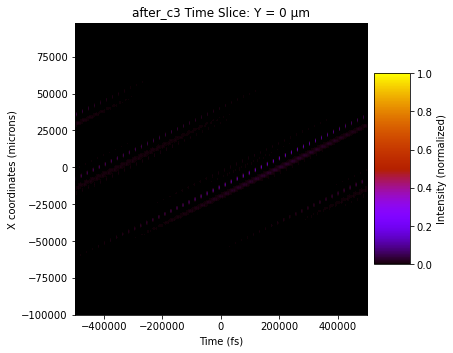

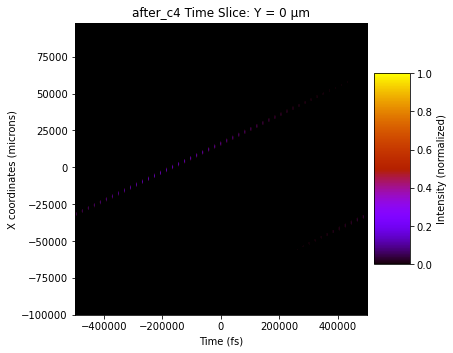

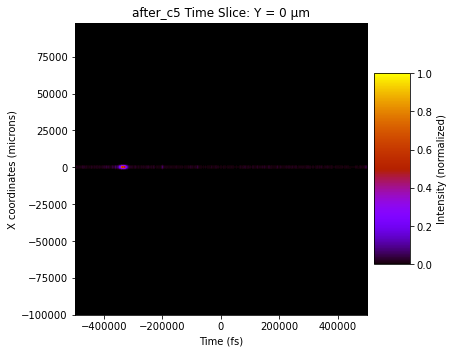

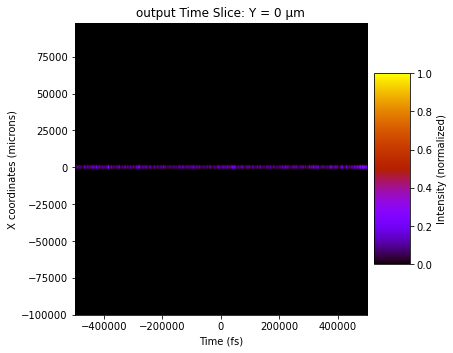

In [8]:
''' time slice '''
print('total {}s, per slice {}ms'.format(round(tfin-tstart,2), round(1000*(tfin-tstart)/pulse.N,2)))

shift = 0
pulse.imshow_time_slice('im0')
pulse.imshow_time_slice('after_c1')
pulse.imshow_time_slice('after_c2')
pulse.imshow_time_slice('after_c3')
pulse.imshow_time_slice('after_c4')
pulse.imshow_time_slice('after_c5')
pulse.imshow_time_slice('output')


for i in range(2):
    winsound.Beep(1000,1000)